<a href="https://colab.research.google.com/github/Tithi-Agarwal/ML-Project/blob/main/LabTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving loan_data.csv to loan_data.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
df = pd.read_csv("loan_data.csv")
print("Loaded shape:", df.shape)
display(df.head())
display(df.info())
display(df.describe(include='all').T)

Loaded shape: (268114, 13)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268114 entries, 0 to 268113
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    268114 non-null  int64  
 1   annual_income         268114 non-null  float64
 2   debt_to_income_ratio  268114 non-null  float64
 3   credit_score          268114 non-null  int64  
 4   loan_amount           268114 non-null  float64
 5   interest_rate         268114 non-null  float64
 6   gender                268114 non-null  object 
 7   marital_status        268114 non-null  object 
 8   education_level       268114 non-null  object 
 9   employment_status     268114 non-null  object 
 10  loan_purpose          268114 non-null  object 
 11  grade_subgrade        268114 non-null  object 
 12  loan_paid_back        268114 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 26.6+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,268114.0,NaN,NaN,NaN,134056.5,77397.989374,0.0,67028.25,134056.5,201084.75,268113.0
annual_income,268114.0,NaN,NaN,NaN,48203.659176,26735.817913,6002.43,27897.19,46552.49,60981.32,393381.74
debt_to_income_ratio,268114.0,NaN,NaN,NaN,0.120764,0.06875,0.011,0.072,0.096,0.156,0.577
credit_score,268114.0,NaN,NaN,NaN,680.831732,55.404553,395.0,646.0,682.0,719.0,849.0
loan_amount,268114.0,NaN,NaN,NaN,15028.884002,6932.802588,500.91,10281.41,15011.15,18872.21,48959.95
interest_rate,268114.0,NaN,NaN,NaN,12.357615,2.008781,3.66,10.99,12.37,13.68,20.84
gender,268114,3,Female,138314,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital_status,268114,4,Single,130461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_level,268114,5,Bachelor's,126443,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_status,268114,5,Employed,203430,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
assert 'loan_paid_back' in df.columns, "Target column 'loan_paid_back' not found!"
print("Target distribution (counts):")
print(df['loan_paid_back'].value_counts(dropna=False))
print("\nTarget distribution (proportions):")
print(df['loan_paid_back'].value_counts(normalize=True, dropna=False))

Target distribution (counts):
loan_paid_back
1    214068
0     54046
Name: count, dtype: int64

Target distribution (proportions):
loan_paid_back
1    0.798422
0    0.201578
Name: proportion, dtype: float64


In [ ]:
# missing values overview
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(20))


Missing values per column:
id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64


In [ ]:
all_cols = df.columns.tolist()
num_cols = ['annual_income','debt_to_income_ratio','credit_score','loan_amount','interest_rate']
# Ensure only columns present are used
num_cols = [c for c in num_cols if c in df.columns]


In [ ]:
cat_nominal = []
cat_ordinal = []

possible_nominal = ['gender','marital_status','employment_status','loan_purpose','subgrade']
possible_ordinal = ['education_level','grade']

for c in possible_nominal:
    if c in df.columns:
        cat_nominal.append(c)
for c in possible_ordinal:
    if c in df.columns:
        cat_ordinal.append(c)

print("Numerical:", num_cols)
print("Categorical (nominal -> one-hot):", cat_nominal)
print("Categorical (candidate ordinal):", cat_ordinal)

Numerical: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
Categorical (nominal -> one-hot): ['gender', 'marital_status', 'employment_status', 'loan_purpose']
Categorical (candidate ordinal): ['education_level']


In [ ]:
# Split grade_subgrade into grade and subgrade
df['grade'] = df['grade_subgrade'].str[0]
df['subgrade'] = df['grade_subgrade'].str[1:].astype(int)

# Drop old combined column
df.drop(columns=['grade_subgrade'], inplace=True)
num_cols = ['annual_income','debt_to_income_ratio','credit_score','loan_amount','interest_rate']

cat_nominal = ['gender','marital_status','employment_status','loan_purpose']
cat_ordinal = ['education_level','grade','subgrade']   # all ordinal now

target = 'loan_paid_back'


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[target, 'id'])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)


(214491, 12) (53623, 12)


In [ ]:
education_order = ['High School','Associate','Bachelor\'s','Master\'s','Doctorate']
grade_order = ['A','B','C','D','E','F','G']


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Identify categories from dataset
education_order = [
    "High School","Associate","Bachelor's","Master's","Doctorate","PhD","Other"
]

grade_order = ['A','B','C','D','E','F','G']

ordinal_encoder = OrdinalEncoder(
    categories=[
        education_order,
        grade_order,
        sorted(df['subgrade'].unique())
    ],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('nom', OneHotEncoder(handle_unknown='ignore'), cat_nominal),
    ('ord', ordinal_encoder, cat_ordinal)
])


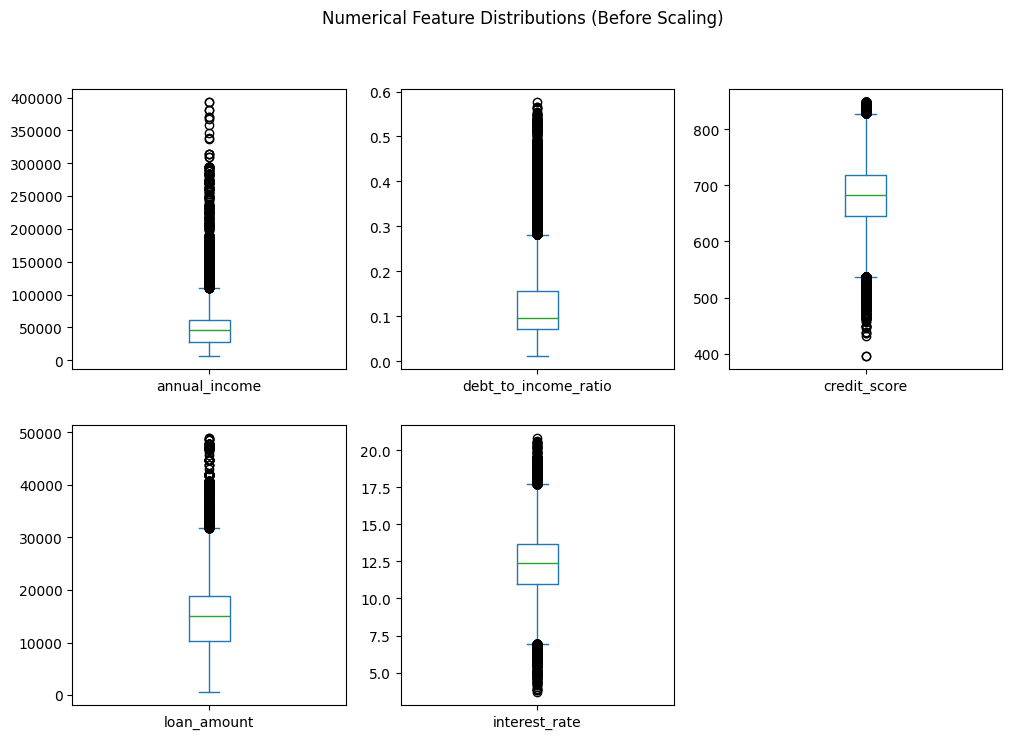

In [ ]:
num_cols = ['annual_income','debt_to_income_ratio','credit_score','loan_amount','interest_rate']

df[num_cols].plot(kind='box', subplots=True, figsize=(12,8), layout=(2,3))
plt.suptitle("Numerical Feature Distributions (Before Scaling)")
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', model)
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['annual_income',
                                                   'debt_to_income_ratio',
                                                   'credit_score',
                                                   'loan_amount',
                                                   'interest_rate']),
                                                 ('nom',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'marital_status',
                                                   'employment_status',
                                                   'loan_purpose']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['High '
                                                                              'School',
                                                                              'Associate',
                                                                              "Bachelor's",
                                                                              "Master's",
                                                                              'Doctorate',
                                                                              'PhD',
                                                                              'Other'],
                                                                             ['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'F',
                                                                              'G'],
                                                                             [np.int64(1),
                                                                              np.int64(2),
                                                                              np.int64(3),
                                                                              np.int64(4),
                                                                              np.int64(5)]],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['education_level', 'grade',
                                                   'subgrade'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

In [ ]:
y_pred = pipeline.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9015720866046286

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.58      0.70     10809
           1       0.90      0.98      0.94     42814

    accuracy                           0.90     53623
   macro avg       0.90      0.78      0.82     53623
weighted avg       0.90      0.90      0.89     53623


Confusion Matrix:
 [[ 6251  4558]
 [  720 42094]]


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred_proba = pipeline.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)


AUC: 0.909180911004116


In [ ]:
edu_groups = X_test['education_level'].unique()

for g in edu_groups:
    idx = X_test['education_level'] == g
    if idx.sum() > 0:
        auc_g = roc_auc_score(y_test[idx], y_pred_proba[idx])
        print(f"Education: {g}, AUC = {auc_g:.4f}")


Education: Bachelor's, AUC = 0.9105
Education: Master's, AUC = 0.9069
Education: High School, AUC = 0.9067
Education: PhD, AUC = 0.9067
Education: Other, AUC = 0.9204


In [ ]:
# --- LOAN PURPOSE AUC ANALYSIS (NEW SECTION) ---
purpose_groups = X_test['loan_purpose'].unique()
results = []

for g in purpose_groups:
    idx = X_test['loan_purpose'] == g
    if idx.sum() > 20:  # avoid super small groups
        auc_g = roc_auc_score(y_test[idx], y_pred_proba[idx])
        results.append((g, auc_g))

df_purpose_auc = pd.DataFrame(results, columns=['loan_purpose','AUC'])
df_purpose_auc_sorted = df_purpose_auc.sort_values(by='AUC', ascending=False)

print("\nAUC by Loan Purpose (sorted):")
display(df_purpose_auc_sorted)



AUC by Loan Purpose (sorted):


,loan_purpose,AUC
1,Education,0.920302
5,Vacation,0.919552
4,Medical,0.915418
7,Other,0.911724
3,Home,0.911074
0,Business,0.909775
2,Debt consolidation,0.908583
6,Car,0.897543


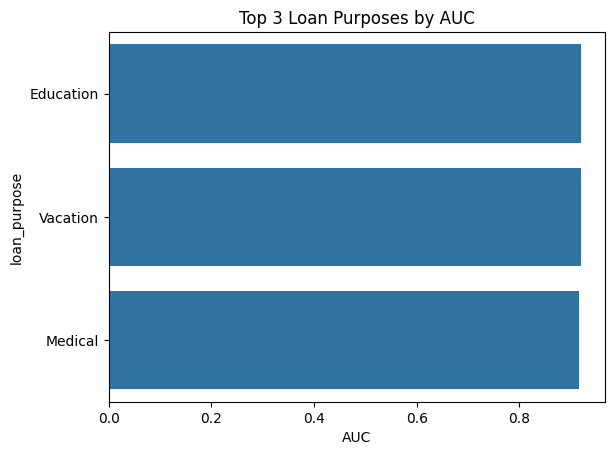

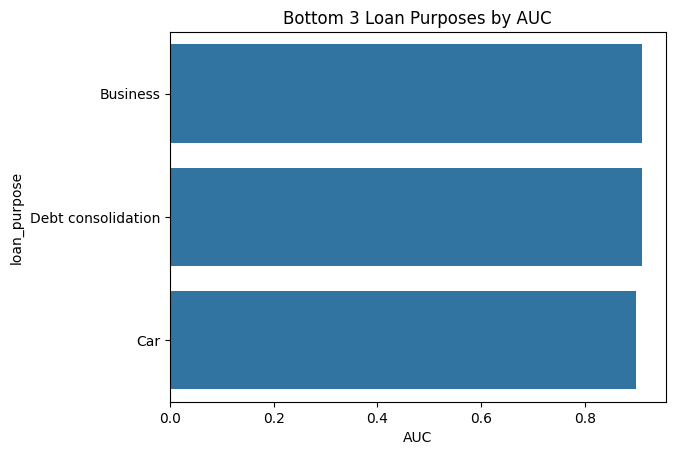

In [ ]:
top3 = df_purpose_auc_sorted.head(3)
bottom3 = df_purpose_auc_sorted.tail(3)

sns.barplot(data=top3, x='AUC', y='loan_purpose')
plt.title("Top 3 Loan Purposes by AUC")
plt.show()

sns.barplot(data=bottom3, x='AUC', y='loan_purpose')
plt.title("Bottom 3 Loan Purposes by AUC")
plt.show()


In [ ]:
purpose_auc = {}

purposes = X_test['loan_purpose'].unique()

for p in purposes:
    idx = X_test['loan_purpose'] == p
    if idx.sum() > 0:
        purpose_auc[p] = roc_auc_score(y_test[idx], y_pred_proba[idx])

sorted_auc = sorted(purpose_auc.items(), key=lambda x: x[1], reverse=True)

print("\nTop 3 loan purposes:")
for k,v in sorted_auc[:3]:
    print(f"{k}: {v:.4f}")

print("\nBottom 3 loan purposes:")
for k,v in sorted_auc[-3:]:
    print(f"{k}: {v:.4f}")



Top 3 loan purposes:
Education: 0.9203
Vacation: 0.9196
Medical: 0.9154

Bottom 3 loan purposes:
Business: 0.9098
Debt consolidation: 0.9086
Car: 0.8975


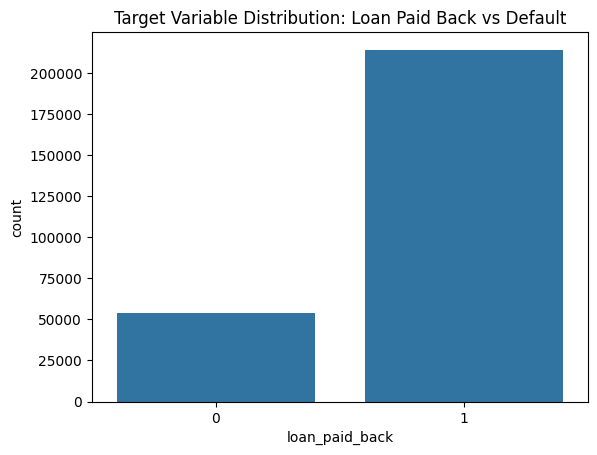

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=df['loan_paid_back'])
plt.title("Target Variable Distribution: Loan Paid Back vs Default")
plt.show()


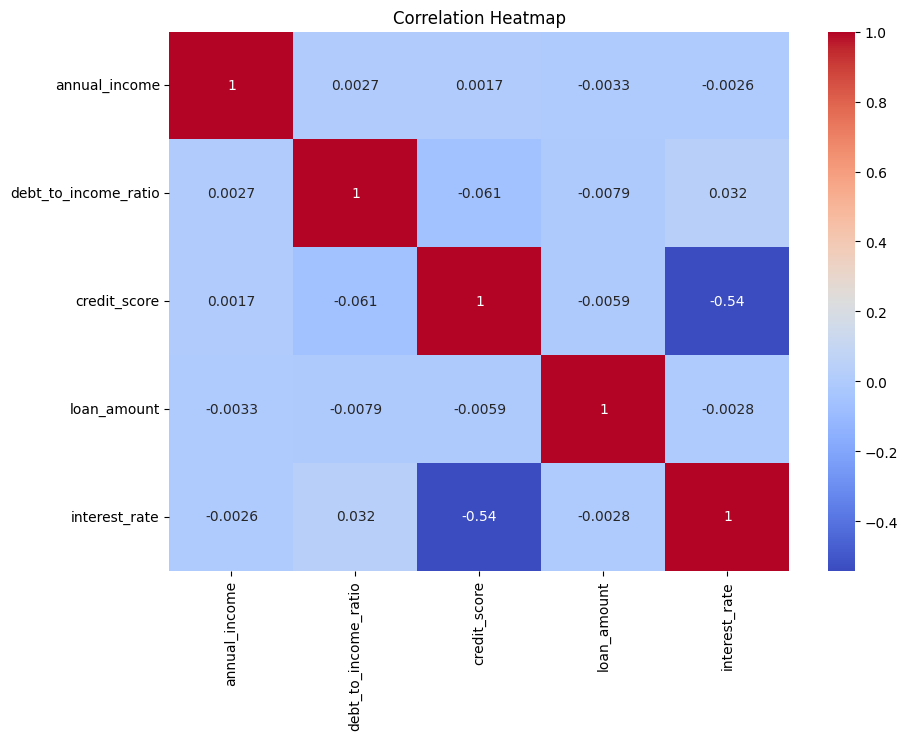

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


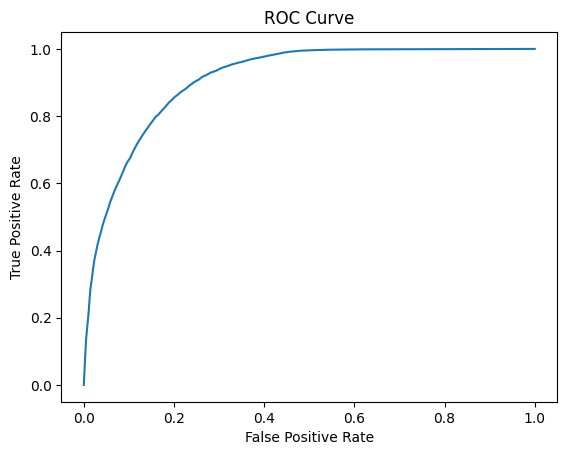

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
